In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from torch import nn
from torch.utils.data import Dataset
from collections import defaultdict
import random
import time
from cesium import featurize
import sncosmo
from astropy.timeseries import LombScargle, LombScargleMultiband

In [2]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [4]:
class LightCurveDataset(Dataset):
    def __init__(self, data_file=None, metadata_file=None):
        self.metadata = pd.read_csv(metadata_file,
                        dtype=defaultdict(lambda : np.float32, {'object_id': np.int32, 'ddf': bool, 'target': np.int8}))
        # Let's remap the target labels in the metadata file
        remap_classes = {6: 0, 15: 1, 16: 2, 42: 3, 52: 4, 53: 5, 62: 6, 64: 7, 65: 8, 67: 9, 88: 10, 90: 11, 92: 12, 95:13, 99: 14}
        self.metadata['target'] = self.metadata['target'].map(remap_classes)
        self.data = pd.read_csv(data_file,
                    dtype={'object_id': np.int32, 'mjd': np.float64, 'passband': np.int8,
                           'flux': np.float32, 'flux_err': np.float32, 'detected': bool})
        # # Let's drop the detected column
        # self.data = self.data.drop(columns='detected')
        # # Let's shift and scale the fluxes and flux errors for each object
        # # Also let's note the flux magnitudes before scaling
        # self.data['flux'] = self.data.groupby(['object_id', 'passband'])['flux'].transform(lambda x: x - x.min())
        # self.data['flux_mag'] = self.data.groupby(['object_id','passband'])['flux'].transform('max')
        # self.data['flux'] = self.data['flux'] / self.data['flux_mag']
        # self.data['flux_err'] = self.data['flux_err'] / self.data['flux_mag']
        # # Let's also scale the flux magnitudes across passbands
        # self.data['flux_mag'] = self.data.groupby(['object_id'])['flux_mag'].transform(lambda x: x / x.max())
        # # Let's sort the data by mjd
        # self.data.sort_values(by='mjd', inplace=True)
        # # Let's shift the days from start
        # self.data['mjd'] = self.data.groupby('object_id')['mjd'].transform(lambda x: x - x.min())
        # # And scale them for no reason whatsoever
        # self.data['mjd'] = self.data['mjd'] / self.data['mjd'].max()
        return

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Grab the metadata of the i-th object
        md = self.metadata.iloc[idx]
        # Grab the light curve data of object with object_id
        lcd = self.data[self.data['object_id'] == md['object_id']].drop(columns='object_id')
        # Now we need to make a tensor out of this
        feature_count = 21
        out_tensor = torch.zeros((len(lcd), feature_count))
        # Keep mjd first
        count = 0
        md_feats = torch.from_numpy(md[['hostgal_photoz', 'hostgal_photoz_err']].to_numpy(np.float32))
        for passband, table in lcd.groupby('passband'):
            # Now for each passband let's put the features
            out_tensor[count:(count + len(table)), 0] = torch.from_numpy(table['mjd'].to_numpy(np.float64))
            out_tensor[count:(count + len(table)), 1:3] = md_feats
            out_tensor[count:(count + len(table)), (3 * passband + 3):(3 * (passband + 1) + 3)] = torch.from_numpy(table[['flux','flux_err', 'flux_mag']].to_numpy(np.float32))
            count += len(table)
        out_tensor = out_tensor[out_tensor[:, 0].argsort(), :]
        return out_tensor, md['target']

In [5]:
class AstroRNN(nn.Module):
    def __init__(self):
        super(AstroRNN, self).__init__()
        self.input_layer = nn.RNN(21, 128, num_layers=3, nonlinearity='tanh')
        self.activation = nn.Tanh()
        self.linear_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 14)

    def forward(self, input_tensor):
        rnn_out, hidden = self.input_layer(input_tensor)
        logits = self.activation(rnn_out[-1, :])
        logits = self.activation(self.linear_layer(logits))
        logits = self.activation(self.linear_layer(logits))
        logits = self.activation(self.linear_layer(logits))
        logits = self.activation(self.output_layer(logits))
        return logits

In [6]:
train_lcd = LightCurveDataset(metadata_file='./training/training_set_metadata.csv',
                              data_file='./training/training_set.csv')

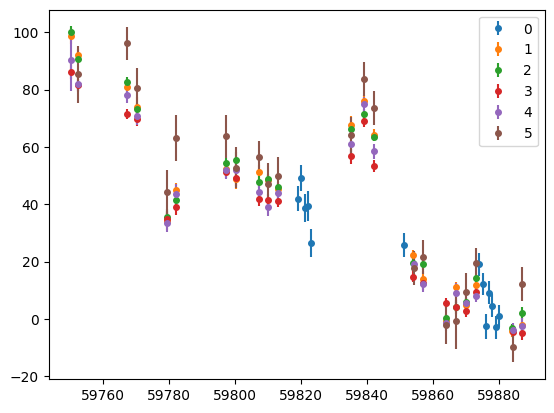

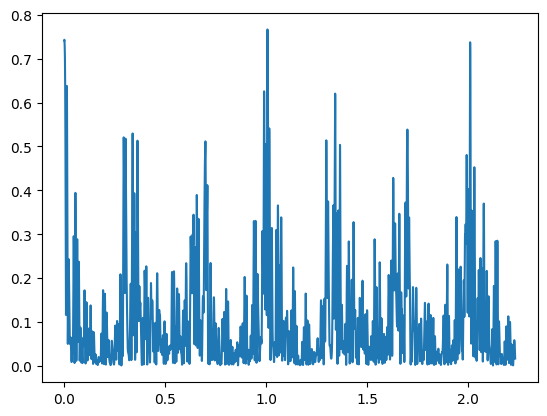

1.0061949532688437


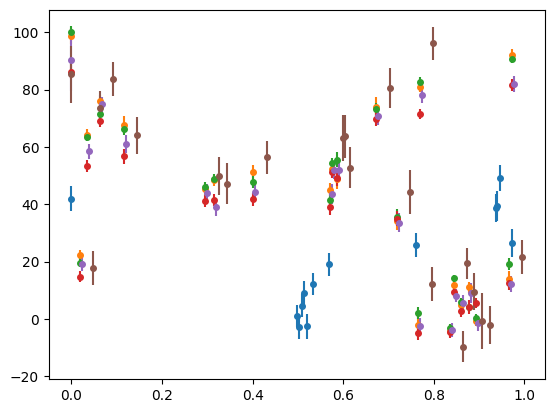

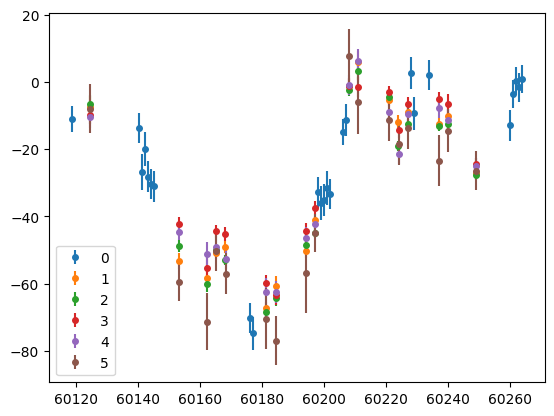

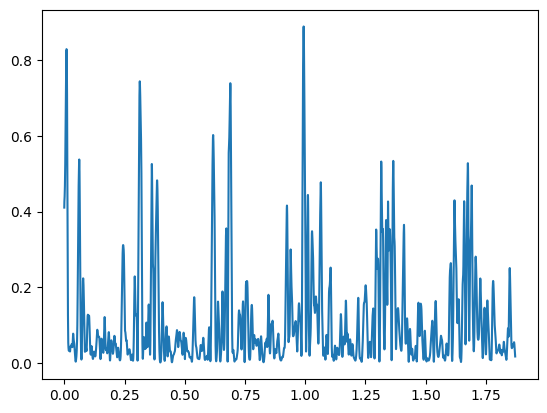

0.993320753525027


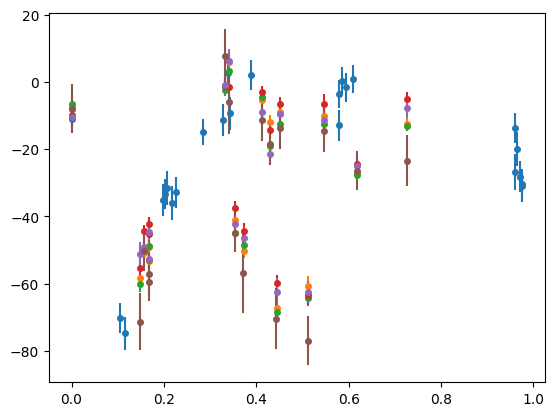

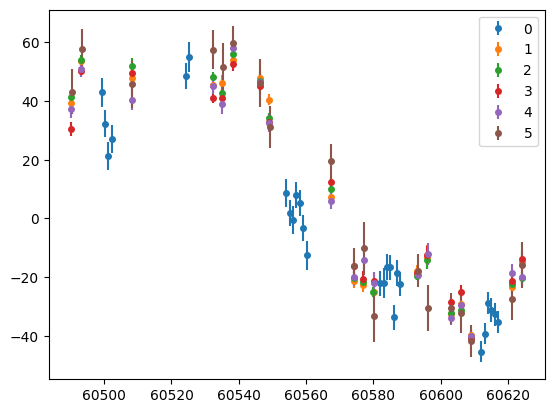

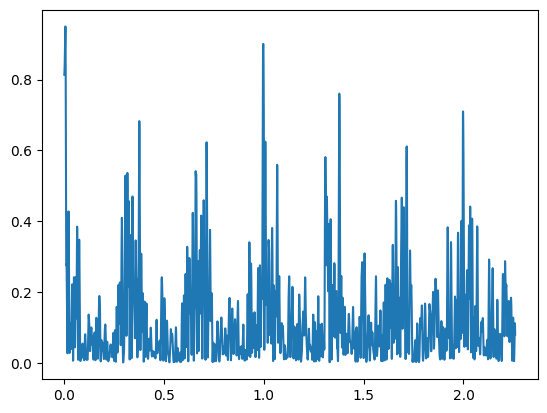

0.0056567294918352775


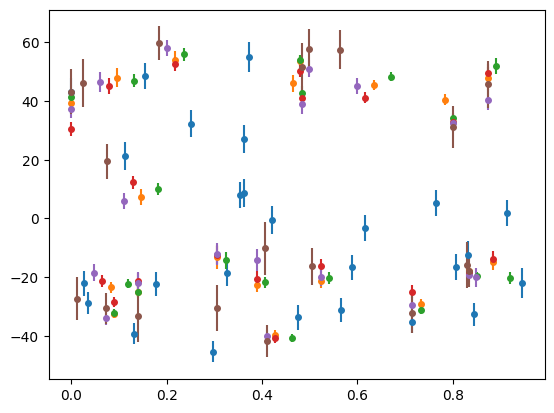

In [33]:
df = train_lcd.data[(train_lcd.data.object_id == 211290)].sort_values(by='mjd')
df['grouper'] = (df['mjd'].diff() > 50).cumsum()
for g, u in df.groupby('grouper'):
    tofittime = []
    tofitflux = []
    tofitbands = []
    tofitdy = []
    for pb, f in u.groupby('passband'):
        plt.errorbar(f['mjd'], f['flux'], f['flux_err'], marker='o', markersize=4,linestyle='none', label=pb)
        tofittime.extend((f['mjd'] - f['mjd'].min()).tolist())
        tofitflux.extend(f['flux'].tolist())
        tofitdy.extend(f['flux_err'].tolist())
        tofitbands.extend([pb] * len(f))
        # plt.scatter(f['mjd'] - f['mjd'].min(), f['flux'], marker='o', s=10, label=pb)
    plt.legend()
    plt.show()
    ls = LombScargleMultiband(tofittime, tofitflux, tofitbands, tofitdy)
    frequency,power = ls.autopower(nyquist_factor=5, samples_per_peak=200)
    # nyquist_factor=2, samples_per_peak=200
    plt.plot(frequency, power)
    plt.show()
    freq = frequency[np.argmax(power)]
    print(freq)
    t_fit = np.linspace(0, 1)
    pow = ls.model(t_fit, freq)
    # plt.plot(t_fit, pow[0,:])
    for pb, f in u.groupby('passband'):
        plt.errorbar(((f['mjd'] - f['mjd'].min()) / freq) % 1,f['flux'],yerr=f['flux_err'],marker='o', markersize=4,linestyle='none')
    plt.show()

In [21]:
train_lcd.metadata

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796539,-51.753708,True,0.0000,0.0000,0.0000,NaN,0.017,12
1,713,53.085938,-27.784405,223.525513,-54.460747,True,1.8181,1.6267,0.2552,45.406300,0.007,10
2,730,33.574219,-6.579593,170.455582,-61.548218,True,0.2320,0.2262,0.0157,40.256100,0.021,3
3,745,0.189873,-45.586655,328.254456,-68.969299,True,0.3037,0.2813,1.1523,40.795101,0.007,11
4,1124,352.711273,-63.823658,316.922302,-51.059402,True,0.1934,0.2415,0.0176,40.416599,0.024,11
...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.718750,-14.940303,172.342697,-72.255676,False,0.0000,0.0000,0.0000,NaN,0.013,8
7844,130755807,120.101349,-62.696659,275.742950,-16.509747,False,0.1725,2.5606,1.1146,46.610802,0.136,11
7845,130762946,203.108109,-55.682144,308.728912,6.727511,False,0.0000,0.0000,0.0000,NaN,0.430,2
7846,130772921,79.101562,-35.501846,239.172241,-33.827843,False,0.0000,0.0000,0.0000,NaN,0.034,8


In [28]:
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]
u = train_lcd.data[(train_lcd.data['object_id'] == 615)].groupby('passband')
times = np.stack([t['mjd'].to_numpy() for _, t in u])
values = np.stack([t['flux'].to_numpy() for _, t in u])
errors = np.stack([t['flux_err'].to_numpy() for _, t in u])
print(times.shape)
fset_cesium = featurize.featurize_time_series(
    times=train_lcd.data[(train_lcd.data['object_id'] == 615) & (train_lcd.data['passband'] == 0)]['mjd'].to_numpy(),
    values=train_lcd.data[(train_lcd.data['object_id'] == 615) & (train_lcd.data['passband'] == 0)]['flux'].to_numpy(),
    errors=train_lcd.data[(train_lcd.data['object_id'] == 615) & (train_lcd.data['passband'] == 0)]['flux_err'].to_numpy(),
    features_to_use=features_to_use,
)

ValueError: all input arrays must have the same shape

In [19]:
fset_cesium

feature,amplitude,percent_beyond_1_std,maximum,max_slope,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average
channel,0,0,0,0,0,0,0,0,0,0,0
0,121.048016,0.47619,125.182808,184.863918,-10.015225,79.958667,0.15873,-116.913223,0.125827,83.275842,-17.061118


In [6]:
# The way I'm doing it, it's possible I don't get certain classes
train_set, test_set = torch.utils.data.random_split(train_lcd, [.80, .20], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 6279, validation examples = 1569


In [7]:
def train(rnn, training_data, n_epoch = 20, n_batch_size = 64, report_every = 1, learning_rate = 0.5):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.8, total_iters=n_epoch)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    generator=torch.Generator(device=device).manual_seed(2024)
    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (input_tensor, label) = training_data[i]
                output = rnn.forward(input_tensor)
                loss = criterion(output, torch.tensor(label))
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (iter, before_lr, after_lr))

    return all_losses

In [8]:
rnn = AstroRNN()
print(rnn)

AstroRNN(
  (input_layer): RNN(21, 128, num_layers=3)
  (activation): Tanh()
  (linear_layer): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=14, bias=True)
)


In [9]:
all_losses = train(rnn, train_set)

training on data set with n = 6279
1 (5%): 	 average batch loss = 2.480637668889583
Epoch 1: SGD lr 0.5000 -> 0.4950
2 (10%): 	 average batch loss = 2.4957601437576153
Epoch 2: SGD lr 0.4950 -> 0.4900


KeyboardInterrupt: 